# BGA-AISNP: Biogeographic Ancestry Classification
## Multi-Continental Population Classification using Ancestry Informative SNPs

This notebook implements a comprehensive two-stage classification pipeline for biogeographic ancestry inference:

### Pipeline Overview:
1. **Data Loading & Exploration** - 258 ancestry informative SNPs (AISNPs)
2. **Data Preprocessing** - Feature encoding, quality control, missing value handling
3. **Continental Classification** - 5-way classification (AFR, AMR, EAS, EUR, SAS)
4. **Population Classification** - Fine-grained classification within each continent
5. **Model Evaluation** - Performance metrics, confusion matrices, cross-validation

### Dataset:
- **258 AISNPs** in standardized genotype count format (0/1/2)
- **2,347 samples** from 24 global populations
- **5 continental groups**: African (AFR), American (AMR), East Asian (EAS), European (EUR), South Asian (SAS)

## 1. Import Required Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Custom models
sys.path.append(os.path.join(os.path.dirname(__file__) if '__file__' in dir() else '.', '..'))
from src.generative_model import GenerativeBGAModel

# Utilities
import joblib
import warnings
warnings.filterwarnings('ignore')

# Visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Explore the Data

In [2]:
# Load the merged dataset
# Dataset: 258 ancestry informative SNPs (AISNPs)
# - 201 SNPs from native-only populations
# - 57 SNPs from East Asian panel (1 duplicate removed: rs1229984)
# - Standardized genotype count format: 0 (REF/REF), 1 (REF/ALT), 2 (ALT/ALT)
data_path = os.path.join('data', 'merged_matrix_201plus58_standardized.csv')
df = pd.read_csv(data_path, index_col=0)

print(f"Dataset loaded successfully!")
print(f"{'='*70}")
print(f"Dataset shape: {df.shape}")
print(f"\nSNP Details:")
print(f"  - Total AISNPs: 258")
print(f"  - Genotype encoding: 0/1/2 (count of alternative alleles)")
print(f"  - Samples: {len(df):,}")
print(f"\nData types:\n{df.dtypes.value_counts()}")
print(f"\nMissing values: {df.isnull().sum().sum()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\n{'='*70}")
print(f"Basic statistics:")
print(df.describe())

Dataset loaded successfully!
Dataset shape: (2347, 260)

SNP Details:
  - Total AISNPs: 258
  - Genotype encoding: 0/1/2 (count of alternative alleles)
  - Samples: 2,347

Data types:
int64     258
object      2
Name: count, dtype: int64

Missing values: 0

First few rows:
         rs2814778  rs11184898  rs12119914  rs3917750  rs11264001  rs2759281  \
HG00096          0           2           1          0           2          1   
HG00097          0           2           0          0           2          1   
HG00099          0           1           1          0           2          0   
HG00100          0           1           0          0           2          0   
HG00101          0           0           1          1           2          0   

         rs9442234  rs819971  rs814856  rs11589429  ...  rs2261033  \
HG00096          1         0         1           0  ...          0   
HG00097          1         0         2           0  ...          0   
HG00099          2         1       

In [3]:
# Examine population metadata
print("="*70)
print("POPULATION METADATA")
print("="*70)

print(f"\nContinental Groups (super_pop):")
print(df['super_pop'].value_counts().sort_index())

print(f"\nNative Populations (pop):")
print(df['pop'].value_counts().sort_index())

# Data quality check
print(f"\n{'='*70}")
print(f"DATA QUALITY:")
print(f"  - Missing in super_pop: {df['super_pop'].isnull().sum()}")
print(f"  - Missing in pop: {df['pop'].isnull().sum()}")
print(f"  - Total populations: {df['pop'].nunique()}")
print(f"  - Total continents: {df['super_pop'].nunique()}")
print(f"{'='*70}")

POPULATION METADATA

Continental Groups (super_pop):
super_pop
AFR    504
AMR    347
EAS    504
EUR    503
SAS    489
Name: count, dtype: int64

Native Populations (pop):
pop
BEB     86
CDX     93
CEU     99
CHB    103
CHS    105
CLM     94
ESN     99
FIN     99
GBR     91
GIH    103
GWD    113
IBS    107
ITU    102
JPT    104
KHV     99
LWK     99
MSL     85
MXL     64
PEL     85
PJL     96
PUR    104
STU    102
TSI    107
YRI    108
Name: count, dtype: int64

DATA QUALITY:
  - Missing in super_pop: 0
  - Missing in pop: 0
  - Total populations: 24
  - Total continents: 5


## 3. Data Preprocessing and Feature Engineering

In [4]:
# Separate features and target labels
# All columns except last two (pop, super_pop) are SNP features
snp_names = df.columns[:-2].tolist()
X = df[snp_names].values.astype(np.float32)
y_super_pop = df['super_pop'].values
y_pop = df['pop'].values

print("="*70)
print("FEATURE EXTRACTION")
print("="*70)
print(f"Number of SNP features: {len(snp_names)}")
print(f"Number of samples: {X.shape[0]:,}")
print(f"Feature matrix shape: {X.shape}")
print(f"\nGenotype values present: {sorted(np.unique(X[~np.isnan(X)]))}")
print(f"\nFirst 10 SNPs: {snp_names[:10]}")
print(f"Last 10 SNPs: {snp_names[-10:]}")
print("="*70)

FEATURE EXTRACTION
Number of SNP features: 258
Number of samples: 2,347
Feature matrix shape: (2347, 258)

Genotype values present: [np.float32(0.0), np.float32(1.0), np.float32(2.0)]

First 10 SNPs: ['rs2814778', 'rs11184898', 'rs12119914', 'rs3917750', 'rs11264001', 'rs2759281', 'rs9442234', 'rs819971', 'rs814856', 'rs11589429']
Last 10 SNPs: ['rs2571389', 'rs2442728', 'rs2261033', 'rs535319466', 'rs2717329', 'rs7799912', 'rs6969817', 'rs2920295', 'rs12006467', 'rs534029120']


In [5]:
# Handle missing values (NaN)
# For now, we'll impute with median per SNP
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

print(f"Missing values after imputation: {np.isnan(X_imputed).sum()}")
print(f"Imputed data shape: {X_imputed.shape}")

# Encode labels
le_super_pop = LabelEncoder()
y_super_pop_encoded = le_super_pop.fit_transform(y_super_pop)

le_pop = LabelEncoder()
y_pop_encoded = le_pop.fit_transform(y_pop)

print(f"\nSuper-pop encoding:")
for i, label in enumerate(le_super_pop.classes_):
    count = sum(y_super_pop_encoded == i)
    print(f"  {label}: {count} samples")

print(f"\nClass imbalance check - Super-pop:")
class_counts = np.bincount(y_super_pop_encoded)
print(f"  Min class: {np.min(class_counts)}, Max class: {np.max(class_counts)}")
print(f"  Imbalance ratio: {np.max(class_counts) / np.min(class_counts):.2f}x")

Missing values after imputation: 0
Imputed data shape: (2347, 258)

Super-pop encoding:
  AFR: 504 samples
  AMR: 347 samples
  EAS: 504 samples
  EUR: 503 samples
  SAS: 489 samples

Class imbalance check - Super-pop:
  Min class: 347, Max class: 504
  Imbalance ratio: 1.45x


## 4. Split Data into Training and Testing Sets

In [6]:
# Stratified train/test split (80/20)
# Using random_state=42 for reproducibility (as per original workflow)
X_train, X_test, y_train_super, y_test_super = train_test_split(
    X_imputed, 
    y_super_pop_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_super_pop_encoded
)

X_train_pop, X_test_pop, y_train_pop, y_test_pop = train_test_split(
    X_imputed,
    y_pop_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_pop_encoded
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Total features: {X_train.shape[1]} SNPs\n")

# Verify stratification
print("Train set super_pop distribution:")
train_dist = np.bincount(y_train_super)
for i, label in enumerate(le_super_pop.classes_):
    print(f"  {label}: {train_dist[i]} ({train_dist[i]/len(y_train_super)*100:.1f}%)")

print("\nTest set super_pop distribution:")
test_dist = np.bincount(y_test_super)
for i, label in enumerate(le_super_pop.classes_):
    print(f"  {label}: {test_dist[i]} ({test_dist[i]/len(y_test_super)*100:.1f}%)")

Training set size: 1877 samples
Test set size: 470 samples
Total features: 258 SNPs

Train set super_pop distribution:
  AFR: 403 (21.5%)
  AMR: 278 (14.8%)
  EAS: 403 (21.5%)
  EUR: 402 (21.4%)
  SAS: 391 (20.8%)

Test set super_pop distribution:
  AFR: 101 (21.5%)
  AMR: 69 (14.7%)
  EAS: 101 (21.5%)
  EUR: 101 (21.5%)
  SAS: 98 (20.9%)


## 5. Stage 1: Continental Classification

First stage of the two-stage pipeline: Classify samples into 5 continental groups (AFR, AMR, EAS, EUR, SAS)

In [7]:
# Stage 1: Continental Classification (5 continents)
print("="*70)
print("STAGE 1: CONTINENTAL CLASSIFICATION")
print("="*70)

# 1. XGBoost Classifier
print("\n[1/2] Training XGBoost for Continental Ancestry...")
xgb_continental = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=len(le_super_pop.classes_),
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42,
    verbosity=0
)

xgb_continental.fit(X_train, y_train_super)
y_pred_xgb_continental = xgb_continental.predict(X_test)
y_pred_proba_xgb_continental = xgb_continental.predict_proba(X_test)
acc_xgb_continental = accuracy_score(y_test_super, y_pred_xgb_continental)

print(f"✓ XGBoost trained successfully")
print(f"  Accuracy: {acc_xgb_continental:.4f} ({acc_xgb_continental*100:.2f}%)")

# 2. Generative Bayesian Model
print(f"\n[2/2] Training Generative Model for Continental Ancestry...")
gen_continental = GenerativeBGAModel(smoothing_alpha=1.0)
gen_continental.fit(X_train, le_super_pop.inverse_transform(y_train_super), snp_names)
y_pred_gen_continental = gen_continental.predict(X_test)
# Convert string predictions back to encoded labels
y_pred_gen_continental_encoded = le_super_pop.transform(y_pred_gen_continental)
acc_gen_continental = accuracy_score(y_test_super, y_pred_gen_continental_encoded)

print(f"✓ Generative model trained successfully")
print(f"  Accuracy: {acc_gen_continental:.4f} ({acc_gen_continental*100:.2f}%)")

# Cross-validation
print(f"\n{'='*70}")
print("CROSS-VALIDATION (5-Fold Stratified)")
print("="*70)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# XGBoost CV
cv_scores_xgb = cross_val_score(xgb_continental, X_train, y_train_super, cv=skf, scoring='accuracy')
print(f"XGBoost CV:    {cv_scores_xgb.mean():.4f} ± {cv_scores_xgb.std()*2:.4f}")

# Generative CV (manual because it's custom model)
cv_scores_gen = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train_super), 1):
    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_train_super[train_idx], y_train_super[val_idx]
    
    gen_fold = GenerativeBGAModel(smoothing_alpha=1.0)
    gen_fold.fit(X_fold_train, le_super_pop.inverse_transform(y_fold_train), snp_names)
    y_fold_pred = gen_fold.predict(X_fold_val)
    y_fold_pred_encoded = le_super_pop.transform(y_fold_pred)
    fold_score = accuracy_score(y_fold_val, y_fold_pred_encoded)
    cv_scores_gen.append(fold_score)

cv_scores_gen = np.array(cv_scores_gen)
print(f"Generative CV: {cv_scores_gen.mean():.4f} ± {cv_scores_gen.std()*2:.4f}")

# Summary
print(f"\n{'='*70}")
print("CONTINENTAL CLASSIFICATION SUMMARY")
print("="*70)
print(f"{'Model':<20} {'Test Accuracy':<20} {'CV Score':<20}")
print("-"*70)
print(f"{'XGBoost':<20} {acc_xgb_continental*100:>6.2f}%{'':<13} {cv_scores_xgb.mean()*100:>6.2f}%{'':<13}")
print(f"{'Generative':<20} {acc_gen_continental*100:>6.2f}%{'':<13} {cv_scores_gen.mean()*100:>6.2f}%{'':<13}")
print("="*70)

# Classification reports
print(f"\n{'='*70}")
print("DETAILED CLASSIFICATION REPORT - XGBoost")
print("="*70)
print(classification_report(y_test_super, y_pred_xgb_continental, 
                          target_names=le_super_pop.classes_, digits=4))

print(f"{'='*70}")
print("DETAILED CLASSIFICATION REPORT - Generative")
print("="*70)
print(classification_report(y_test_super, y_pred_gen_continental_encoded, 
                          target_names=le_super_pop.classes_, digits=4))

STAGE 1: CONTINENTAL CLASSIFICATION

[1/2] Training XGBoost for Continental Ancestry...
✓ XGBoost trained successfully
  Accuracy: 0.9830 (98.30%)

[2/2] Training Generative Model for Continental Ancestry...
✓ Generative model trained successfully
  Accuracy: 0.9702 (97.02%)

CROSS-VALIDATION (5-Fold Stratified)
XGBoost CV:    0.9771 ± 0.0115
Generative CV: 0.9723 ± 0.0080

CONTINENTAL CLASSIFICATION SUMMARY
Model                Test Accuracy        CV Score            
----------------------------------------------------------------------
XGBoost               98.30%               97.71%             
Generative            97.02%               97.23%             

DETAILED CLASSIFICATION REPORT - XGBoost
              precision    recall  f1-score   support

         AFR     1.0000    1.0000    1.0000       101
         AMR     1.0000    0.8841    0.9385        69
         EAS     1.0000    1.0000    1.0000       101
         EUR     0.9352    1.0000    0.9665       101
         SAS   

## 6. Stage 2: Population Classification within Continents

Second stage: Fine-grained classification of native populations within each continental group.

Each continent has distinct population structures:
- **AFR (Africa)**: 5 West African populations
- **AMR (Americas)**: 4 Native American populations  
- **EAS (East Asia)**: 5 East Asian populations
- **EUR (Europe)**: 5 European populations
- **SAS (South Asia)**: 5 South Asian populations

### 2.1: AFR (African) - 5 Populations

In [8]:
# Lọc chỉ mẫu AFR từ dataset
df_afr = df[df['super_pop'] == 'AFR'].copy()
print(f"AFR subset: {df_afr.shape}")
print(f"\nAFR populations:")
print(df_afr['pop'].value_counts())

# Split X, y
X_afr = X_imputed[df['super_pop'] == 'AFR']
y_afr = df_afr['pop'].values

# Encode labels
le_afr = LabelEncoder()
y_afr_encoded = le_afr.fit_transform(y_afr)

print(f"\nAFR populations: {le_afr.classes_}")
print(f"Number of populations: {len(le_afr.classes_)}")

AFR subset: (504, 260)

AFR populations:
pop
GWD    113
YRI    108
ESN     99
LWK     99
MSL     85
Name: count, dtype: int64

AFR populations: ['ESN' 'GWD' 'LWK' 'MSL' 'YRI']
Number of populations: 5


In [9]:
# Train/test split cho AFR
from sklearn.model_selection import train_test_split

X_train_afr, X_test_afr, y_train_afr, y_test_afr = train_test_split(
    X_afr, y_afr_encoded, test_size=0.2, random_state=42, stratify=y_afr_encoded
)

print(f"AFR Train size: {len(y_train_afr)}")
print(f"AFR Test size: {len(y_test_afr)}")

# Train XGBoost
from xgboost import XGBClassifier

xgb_afr = XGBClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss'
)
xgb_afr.fit(X_train_afr, y_train_afr)

# Evaluate XGBoost
y_pred_xgb_afr = xgb_afr.predict(X_test_afr)
acc_xgb_afr = accuracy_score(y_test_afr, y_pred_xgb_afr)

print(f"\n{'='*70}")
print(f"AFR - XGBoost Results")
print(f"{'='*70}")
print(f"Accuracy: {acc_xgb_afr:.4f} ({acc_xgb_afr*100:.2f}%)")
print(f"\nClassification Report:")
print(classification_report(y_test_afr, y_pred_xgb_afr, target_names=le_afr.classes_, digits=4))

# Train Generative Model
gen_afr = GenerativeBGAModel(smoothing_alpha=1.0)
gen_afr.fit(X_train_afr, le_afr.inverse_transform(y_train_afr), snp_names)

# Evaluate Generative
y_pred_gen_afr = gen_afr.predict(X_test_afr)
y_pred_gen_afr_encoded = le_afr.transform(y_pred_gen_afr)
acc_gen_afr = accuracy_score(y_test_afr, y_pred_gen_afr_encoded)

print(f"\n{'='*70}")
print(f"AFR - Generative Model Results")
print(f"{'='*70}")
print(f"Accuracy: {acc_gen_afr:.4f} ({acc_gen_afr*100:.2f}%)")
print(f"\nClassification Report:")
print(classification_report(y_test_afr, y_pred_gen_afr_encoded, target_names=le_afr.classes_, digits=4))

# 5-Fold Cross Validation
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_xgb_afr = cross_val_score(xgb_afr, X_afr, y_afr_encoded, cv=cv, scoring='accuracy')
print(f"\n{'='*70}")
print(f"AFR - 5-Fold Cross Validation")
print(f"{'='*70}")
print(f"XGBoost CV Accuracy: {cv_xgb_afr.mean():.4f} (+/- {cv_xgb_afr.std()*2:.4f})")

# Generative CV
cv_scores_gen_afr = []
for fold, (train_idx, test_idx) in enumerate(cv.split(X_afr, y_afr_encoded)):
    X_train_cv, X_test_cv = X_afr[train_idx], X_afr[test_idx]
    y_train_cv, y_test_cv = y_afr[train_idx], y_afr[test_idx]
    
    gen_cv = GenerativeBGAModel(smoothing_alpha=1.0)
    gen_cv.fit(X_train_cv, y_train_cv, snp_names)
    y_pred_cv = gen_cv.predict(X_test_cv)
    
    fold_acc = accuracy_score(y_test_cv, y_pred_cv)
    cv_scores_gen_afr.append(fold_acc)

cv_scores_gen_afr = np.array(cv_scores_gen_afr)
print(f"Generative CV Accuracy: {cv_scores_gen_afr.mean():.4f} (+/- {cv_scores_gen_afr.std()*2:.4f})")

AFR Train size: 403
AFR Test size: 101

AFR - XGBoost Results
Accuracy: 0.5248 (52.48%)

Classification Report:
              precision    recall  f1-score   support

         ESN     0.4000    0.3000    0.3429        20
         GWD     0.4400    0.4783    0.4583        23
         LWK     0.7647    0.6500    0.7027        20
         MSL     0.5000    0.4118    0.4516        17
         YRI     0.5333    0.7619    0.6275        21

    accuracy                         0.5248       101
   macro avg     0.5276    0.5204    0.5166       101
weighted avg     0.5259    0.5248    0.5179       101


AFR - Generative Model Results
Accuracy: 0.6634 (66.34%)

Classification Report:
              precision    recall  f1-score   support

         ESN     0.5789    0.5500    0.5641        20
         GWD     0.6800    0.7391    0.7083        23
         LWK     0.8824    0.7500    0.8108        20
         MSL     0.6000    0.3529    0.4444        17
         YRI     0.6000    0.8571    0.7059   

### 2.2: AMR (American) - 4 Populations

In [10]:
# Lọc chỉ mẫu AMR từ dataset
df_amr = df[df['super_pop'] == 'AMR'].copy()
print(f"AMR subset: {df_amr.shape}")
print(f"\nAMR populations:")
print(df_amr['pop'].value_counts())

X_amr = X_imputed[df['super_pop'] == 'AMR']
y_amr = df_amr['pop'].values

le_amr = LabelEncoder()
y_amr_encoded = le_amr.fit_transform(y_amr)

# Train/test split
X_train_amr, X_test_amr, y_train_amr, y_test_amr = train_test_split(
    X_amr, y_amr_encoded, test_size=0.2, random_state=42, stratify=y_amr_encoded
)

# XGBoost
xgb_amr = XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.1, random_state=42, eval_metric='mlogloss')
xgb_amr.fit(X_train_amr, y_train_amr)
y_pred_xgb_amr = xgb_amr.predict(X_test_amr)
acc_xgb_amr = accuracy_score(y_test_amr, y_pred_xgb_amr)

print(f"\n{'='*70}")
print(f"AMR - XGBoost: {acc_xgb_amr:.4f} ({acc_xgb_amr*100:.2f}%)")
print(classification_report(y_test_amr, y_pred_xgb_amr, target_names=le_amr.classes_, digits=4))

# Generative
gen_amr = GenerativeBGAModel(smoothing_alpha=1.0)
gen_amr.fit(X_train_amr, le_amr.inverse_transform(y_train_amr), snp_names)
y_pred_gen_amr = gen_amr.predict(X_test_amr)
y_pred_gen_amr_encoded = le_amr.transform(y_pred_gen_amr)
acc_gen_amr = accuracy_score(y_test_amr, y_pred_gen_amr_encoded)

print(f"\n{'='*70}")
print(f"AMR - Generative: {acc_gen_amr:.4f} ({acc_gen_amr*100:.2f}%)")
print(classification_report(y_test_amr, y_pred_gen_amr_encoded, target_names=le_amr.classes_, digits=4))

# Cross Validation
cv_xgb_amr = cross_val_score(xgb_amr, X_amr, y_amr_encoded, cv=cv, scoring='accuracy')
print(f"\n{'='*70}")
print(f"AMR - XGBoost CV: {cv_xgb_amr.mean():.4f} (+/- {cv_xgb_amr.std()*2:.4f})")

AMR subset: (347, 260)

AMR populations:
pop
PUR    104
CLM     94
PEL     85
MXL     64
Name: count, dtype: int64

AMR - XGBoost: 0.5857 (58.57%)
              precision    recall  f1-score   support

         CLM     0.5455    0.6316    0.5854        19
         MXL     0.4000    0.3077    0.3478        13
         PEL     0.6111    0.6471    0.6286        17
         PUR     0.7000    0.6667    0.6829        21

    accuracy                         0.5857        70
   macro avg     0.5641    0.5632    0.5612        70
weighted avg     0.5808    0.5857    0.5810        70


AMR - Generative: 0.6714 (67.14%)
              precision    recall  f1-score   support

         CLM     0.5500    0.5789    0.5641        19
         MXL     0.5000    0.4615    0.4800        13
         PEL     0.8333    0.8824    0.8571        17
         PUR     0.7500    0.7143    0.7317        21

    accuracy                         0.6714        70
   macro avg     0.6583    0.6593    0.6582        70
wei

### 2.3: EAS (East Asian) - 5 Populations

In [11]:
# Lọc chỉ mẫu EAS từ dataset
df_eas = df[df['super_pop'] == 'EAS'].copy()
print(f"EAS subset: {df_eas.shape}")
print(f"\nEAS populations:")
print(df_eas['pop'].value_counts())

X_eas = X_imputed[df['super_pop'] == 'EAS']
y_eas = df_eas['pop'].values

le_eas = LabelEncoder()
y_eas_encoded = le_eas.fit_transform(y_eas)

# Train/test split
X_train_eas, X_test_eas, y_train_eas, y_test_eas = train_test_split(
    X_eas, y_eas_encoded, test_size=0.2, random_state=42, stratify=y_eas_encoded
)

# XGBoost
xgb_eas = XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.1, random_state=42, eval_metric='mlogloss')
xgb_eas.fit(X_train_eas, y_train_eas)
y_pred_xgb_eas = xgb_eas.predict(X_test_eas)
acc_xgb_eas = accuracy_score(y_test_eas, y_pred_xgb_eas)

print(f"\n{'='*70}")
print(f"EAS - XGBoost: {acc_xgb_eas:.4f} ({acc_xgb_eas*100:.2f}%)")
print(classification_report(y_test_eas, y_pred_xgb_eas, target_names=le_eas.classes_, digits=4))

# Generative
gen_eas = GenerativeBGAModel(smoothing_alpha=1.0)
gen_eas.fit(X_train_eas, le_eas.inverse_transform(y_train_eas), snp_names)
y_pred_gen_eas = gen_eas.predict(X_test_eas)
y_pred_gen_eas_encoded = le_eas.transform(y_pred_gen_eas)
acc_gen_eas = accuracy_score(y_test_eas, y_pred_gen_eas_encoded)

print(f"\n{'='*70}")
print(f"EAS - Generative: {acc_gen_eas:.4f} ({acc_gen_eas*100:.2f}%)")
print(classification_report(y_test_eas, y_pred_gen_eas_encoded, target_names=le_eas.classes_, digits=4))

# Cross Validation
cv_xgb_eas = cross_val_score(xgb_eas, X_eas, y_eas_encoded, cv=cv, scoring='accuracy')
print(f"\n{'='*70}")
print(f"EAS - XGBoost CV: {cv_xgb_eas.mean():.4f} (+/- {cv_xgb_eas.std()*2:.4f})")
print(f"\n💡 So sánh với EAS từ paper (58 SNPs): XGBoost=69.3%, Generative=76.2%")
print(f"   EAS với 201 SNPs: XGBoost={acc_xgb_eas*100:.1f}%, Generative={acc_gen_eas*100:.1f}%")

EAS subset: (504, 260)

EAS populations:
pop
CHS    105
JPT    104
CHB    103
KHV     99
CDX     93
Name: count, dtype: int64

EAS - XGBoost: 0.7129 (71.29%)
              precision    recall  f1-score   support

         CDX     0.6364    0.7778    0.7000        18
         CHB     0.7500    0.5714    0.6486        21
         CHS     0.6250    0.7143    0.6667        21
         JPT     1.0000    0.9048    0.9500        21
         KHV     0.6000    0.6000    0.6000        20

    accuracy                         0.7129       101
   macro avg     0.7223    0.7137    0.7131       101
weighted avg     0.7260    0.7129    0.7146       101


EAS - Generative: 0.7426 (74.26%)
              precision    recall  f1-score   support

         CDX     0.6364    0.7778    0.7000        18
         CHB     0.7778    0.6667    0.7179        21
         CHS     0.7000    0.6667    0.6829        21
         JPT     0.9545    1.0000    0.9767        21
         KHV     0.6316    0.6000    0.6154    

### 2.4: EUR (European) - 5 Populations

In [12]:
# Lọc chỉ mẫu EUR từ dataset
df_eur = df[df['super_pop'] == 'EUR'].copy()
print(f"EUR subset: {df_eur.shape}")
print(f"\nEUR populations:")
print(df_eur['pop'].value_counts())

X_eur = X_imputed[df['super_pop'] == 'EUR']
y_eur = df_eur['pop'].values

le_eur = LabelEncoder()
y_eur_encoded = le_eur.fit_transform(y_eur)

# Train/test split
X_train_eur, X_test_eur, y_train_eur, y_test_eur = train_test_split(
    X_eur, y_eur_encoded, test_size=0.2, random_state=42, stratify=y_eur_encoded
)

# XGBoost
xgb_eur = XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.1, random_state=42, eval_metric='mlogloss')
xgb_eur.fit(X_train_eur, y_train_eur)
y_pred_xgb_eur = xgb_eur.predict(X_test_eur)
acc_xgb_eur = accuracy_score(y_test_eur, y_pred_xgb_eur)

print(f"\n{'='*70}")
print(f"EUR - XGBoost: {acc_xgb_eur:.4f} ({acc_xgb_eur*100:.2f}%)")
print(classification_report(y_test_eur, y_pred_xgb_eur, target_names=le_eur.classes_, digits=4))

# Generative
gen_eur = GenerativeBGAModel(smoothing_alpha=1.0)
gen_eur.fit(X_train_eur, le_eur.inverse_transform(y_train_eur), snp_names)
y_pred_gen_eur = gen_eur.predict(X_test_eur)
y_pred_gen_eur_encoded = le_eur.transform(y_pred_gen_eur)
acc_gen_eur = accuracy_score(y_test_eur, y_pred_gen_eur_encoded)

print(f"\n{'='*70}")
print(f"EUR - Generative: {acc_gen_eur:.4f} ({acc_gen_eur*100:.2f}%)")
print(classification_report(y_test_eur, y_pred_gen_eur_encoded, target_names=le_eur.classes_, digits=4))

# Cross Validation
cv_xgb_eur = cross_val_score(xgb_eur, X_eur, y_eur_encoded, cv=cv, scoring='accuracy')
print(f"\n{'='*70}")
print(f"EUR - XGBoost CV: {cv_xgb_eur.mean():.4f} (+/- {cv_xgb_eur.std()*2:.4f})")

EUR subset: (503, 260)

EUR populations:
pop
IBS    107
TSI    107
FIN     99
CEU     99
GBR     91
Name: count, dtype: int64

EUR - XGBoost: 0.5743 (57.43%)
              precision    recall  f1-score   support

         CEU     0.4444    0.4000    0.4211        20
         FIN     0.5652    0.6500    0.6047        20
         GBR     0.5000    0.3333    0.4000        18
         IBS     0.6818    0.6818    0.6818        22
         TSI     0.6154    0.7619    0.6809        21

    accuracy                         0.5743       101
   macro avg     0.5614    0.5654    0.5577       101
weighted avg     0.5655    0.5743    0.5645       101


EUR - Generative: 0.6733 (67.33%)
              precision    recall  f1-score   support

         CEU     0.5714    0.6000    0.5854        20
         FIN     0.8000    0.8000    0.8000        20
         GBR     0.5556    0.5556    0.5556        18
         IBS     0.7273    0.7273    0.7273        22
         TSI     0.7000    0.6667    0.6829    

### 2.5: SAS (South Asian) - 5 Populations

In [13]:
# Lọc chỉ mẫu SAS từ dataset
df_sas = df[df['super_pop'] == 'SAS'].copy()
print(f"SAS subset: {df_sas.shape}")
print(f"\nSAS populations:")
print(df_sas['pop'].value_counts())

X_sas = X_imputed[df['super_pop'] == 'SAS']
y_sas = df_sas['pop'].values

le_sas = LabelEncoder()
y_sas_encoded = le_sas.fit_transform(y_sas)

# Train/test split
X_train_sas, X_test_sas, y_train_sas, y_test_sas = train_test_split(
    X_sas, y_sas_encoded, test_size=0.2, random_state=42, stratify=y_sas_encoded
)

# XGBoost
xgb_sas = XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.1, random_state=42, eval_metric='mlogloss')
xgb_sas.fit(X_train_sas, y_train_sas)
y_pred_xgb_sas = xgb_sas.predict(X_test_sas)
acc_xgb_sas = accuracy_score(y_test_sas, y_pred_xgb_sas)

print(f"\n{'='*70}")
print(f"SAS - XGBoost: {acc_xgb_sas:.4f} ({acc_xgb_sas*100:.2f}%)")
print(classification_report(y_test_sas, y_pred_xgb_sas, target_names=le_sas.classes_, digits=4))

# Generative
gen_sas = GenerativeBGAModel(smoothing_alpha=1.0)
gen_sas.fit(X_train_sas, le_sas.inverse_transform(y_train_sas), snp_names)
y_pred_gen_sas = gen_sas.predict(X_test_sas)
y_pred_gen_sas_encoded = le_sas.transform(y_pred_gen_sas)
acc_gen_sas = accuracy_score(y_test_sas, y_pred_gen_sas_encoded)

print(f"\n{'='*70}")
print(f"SAS - Generative: {acc_gen_sas:.4f} ({acc_gen_sas*100:.2f}%)")
print(classification_report(y_test_sas, y_pred_gen_sas_encoded, target_names=le_sas.classes_, digits=4))

# Cross Validation
cv_xgb_sas = cross_val_score(xgb_sas, X_sas, y_sas_encoded, cv=cv, scoring='accuracy')
print(f"\n{'='*70}")
print(f"SAS - XGBoost CV: {cv_xgb_sas.mean():.4f} (+/- {cv_xgb_sas.std()*2:.4f})")

SAS subset: (489, 260)

SAS populations:
pop
GIH    103
ITU    102
STU    102
PJL     96
BEB     86
Name: count, dtype: int64

SAS - XGBoost: 0.3469 (34.69%)
              precision    recall  f1-score   support

         BEB     0.2222    0.1176    0.1538        17
         GIH     0.4286    0.5714    0.4898        21
         ITU     0.2941    0.2381    0.2632        21
         PJL     0.4000    0.3158    0.3529        19
         STU     0.3103    0.4500    0.3673        20

    accuracy                         0.3469        98
   macro avg     0.3311    0.3386    0.3254        98
weighted avg     0.3343    0.3469    0.3314        98


SAS - Generative: 0.4694 (46.94%)
              precision    recall  f1-score   support

         BEB     0.3636    0.2353    0.2857        17
         GIH     0.5263    0.4762    0.5000        21
         ITU     0.3810    0.3810    0.3810        21
         PJL     0.7333    0.5789    0.6471        19
         STU     0.4062    0.6500    0.5000    

## 7. Results Summary and Visualization

                         BIOGEOGRAPHIC ANCESTRY CLASSIFICATION RESULTS

--------------------------------STAGE 1: CONTINENTAL CLASSIFICATION---------------------------------

Model                Test Accuracy             CV Score            
----------------------------------------------------------------------------------------------------
XGBoost              0.9830 ( 98.30%)           0.9771 ± 0.0115
Generative           0.9702 ( 97.02%)           0.9723 ± 0.0080

Test samples: 470 | Training samples: 1,877

-------------------------STAGE 2: POPULATION CLASSIFICATION (PER CONTINENT)-------------------------

Continent    Pops   Samples    XGBoost            CV (±2σ)             Generative         Best Model     
----------------------------------------------------------------------------------------------------
AFR          5      504         52.48%             52.97% ± 6.80%          66.34%            Generative (66.34%)
AMR          4      347         58.57%             62.83% ± 5

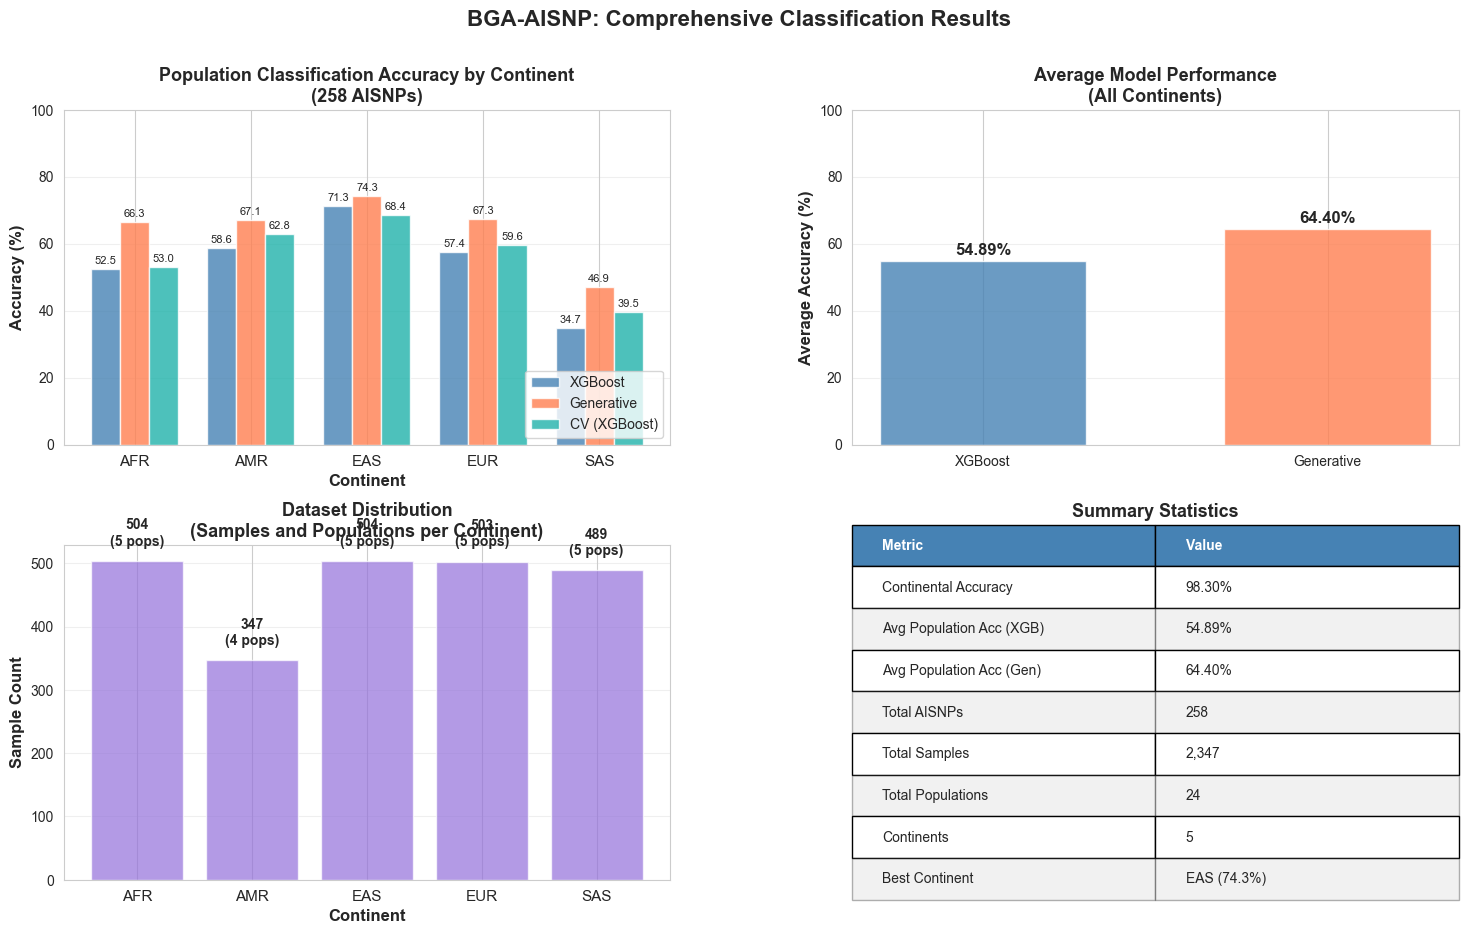

In [14]:
# Comprehensive results summary across all continents
import matplotlib.pyplot as plt
import numpy as np

results_summary = {
    'AFR': {
        'XGBoost': acc_xgb_afr,
        'Generative': acc_gen_afr,
        'CV_XGBoost': cv_xgb_afr.mean(),
        'populations': len(le_afr.classes_),
        'samples': len(df_afr)
    },
    'AMR': {
        'XGBoost': acc_xgb_amr,
        'Generative': acc_gen_amr,
        'CV_XGBoost': cv_xgb_amr.mean(),
        'populations': len(le_amr.classes_),
        'samples': len(df_amr)
    },
    'EAS': {
        'XGBoost': acc_xgb_eas,
        'Generative': acc_gen_eas,
        'CV_XGBoost': cv_xgb_eas.mean(),
        'populations': len(le_eas.classes_),
        'samples': len(df_eas)
    },
    'EUR': {
        'XGBoost': acc_xgb_eur,
        'Generative': acc_gen_eur,
        'CV_XGBoost': cv_xgb_eur.mean(),
        'populations': len(le_eur.classes_),
        'samples': len(df_eur)
    },
    'SAS': {
        'XGBoost': acc_xgb_sas,
        'Generative': acc_gen_sas,
        'CV_XGBoost': cv_xgb_sas.mean(),
        'populations': len(le_sas.classes_),
        'samples': len(df_sas)
    }
}

# Print comprehensive summary table
print("="*100)
print(" "*25 + "BIOGEOGRAPHIC ANCESTRY CLASSIFICATION RESULTS")
print("="*100)
print(f"\n{'STAGE 1: CONTINENTAL CLASSIFICATION':-^100}")
print(f"\n{'Model':<20} {'Test Accuracy':<25} {'CV Score':<20}")
print("-"*100)
print(f"{'XGBoost':<20} {acc_xgb_continental:.4f} ({acc_xgb_continental*100:>6.2f}%){'':<10} {cv_scores_xgb.mean():.4f} ± {cv_scores_xgb.std()*2:.4f}")
print(f"{'Generative':<20} {acc_gen_continental:.4f} ({acc_gen_continental*100:>6.2f}%){'':<10} {cv_scores_gen.mean():.4f} ± {cv_scores_gen.std()*2:.4f}")
print(f"\nTest samples: {len(y_test_super):,} | Training samples: {len(y_train_super):,}")
print("="*100)

print(f"\n{'STAGE 2: POPULATION CLASSIFICATION (PER CONTINENT)':-^100}")
print(f"\n{'Continent':<12} {'Pops':<6} {'Samples':<10} {'XGBoost':<18} {'CV (±2σ)':<20} {'Generative':<18} {'Best Model':<15}")
print("-"*100)

for continent, results in results_summary.items():
    xgb_acc = results['XGBoost'] * 100
    gen_acc = results['Generative'] * 100
    cv_mean = results['CV_XGBoost'] * 100
    
    best = 'XGBoost' if xgb_acc > gen_acc else 'Generative'
    best_acc = max(xgb_acc, gen_acc)
    
    # Get CV std for this continent
    if continent == 'AFR':
        cv_std = cv_xgb_afr.std() * 2 * 100
    elif continent == 'AMR':
        cv_std = cv_xgb_amr.std() * 2 * 100
    elif continent == 'EAS':
        cv_std = cv_xgb_eas.std() * 2 * 100
    elif continent == 'EUR':
        cv_std = cv_xgb_eur.std() * 2 * 100
    else:  # SAS
        cv_std = cv_xgb_sas.std() * 2 * 100
    
    print(f"{continent:<12} {results['populations']:<6} {results['samples']:<10} "
          f"{xgb_acc:>6.2f}%{'':<11} {cv_mean:>6.2f}% ± {cv_std:>4.2f}%{'':<8} "
          f"{gen_acc:>6.2f}%{'':<11} {best:<10} ({best_acc:.2f}%)")

print("="*100)

# Calculate overall statistics
avg_xgb = np.mean([r['XGBoost'] for r in results_summary.values()]) * 100
avg_gen = np.mean([r['Generative'] for r in results_summary.values()]) * 100
avg_cv = np.mean([r['CV_XGBoost'] for r in results_summary.values()]) * 100

print(f"\n{'OVERALL STATISTICS':-^100}")
print(f"  Average XGBoost Accuracy:    {avg_xgb:.2f}%")
print(f"  Average Generative Accuracy: {avg_gen:.2f}%")
print(f"  Average CV Score:            {avg_cv:.2f}%")
print(f"  Best Performing Continent:   {max(results_summary.items(), key=lambda x: max(x[1]['XGBoost'], x[1]['Generative']))[0]}")
print(f"  Total Populations Classified: {sum(r['populations'] for r in results_summary.values())}")
print(f"  Dataset: 258 AISNPs (standardized genotype count format)")
print("="*100)

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. Continental classification (top left)
ax1 = fig.add_subplot(gs[0, 0])
continents = list(results_summary.keys())
xgb_scores = [results_summary[c]['XGBoost']*100 for c in continents]
gen_scores = [results_summary[c]['Generative']*100 for c in continents]
cv_scores_list = [results_summary[c]['CV_XGBoost']*100 for c in continents]

x = np.arange(len(continents))
width = 0.25

bars1 = ax1.bar(x - width, xgb_scores, width, label='XGBoost', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x, gen_scores, width, label='Generative', color='coral', alpha=0.8)
bars3 = ax1.bar(x + width, cv_scores_list, width, label='CV (XGBoost)', color='lightseagreen', alpha=0.8)

ax1.set_xlabel('Continent', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Population Classification Accuracy by Continent\n(258 AISNPs)', 
              fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(continents, fontsize=11)
ax1.legend(fontsize=10, loc='lower right')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 100)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=8)

# 2. Model comparison (top right)
ax2 = fig.add_subplot(gs[0, 1])
models = ['XGBoost', 'Generative']
avg_scores = [avg_xgb, avg_gen]
colors_model = ['steelblue', 'coral']

bars = ax2.bar(models, avg_scores, color=colors_model, alpha=0.8, width=0.6)
ax2.set_ylabel('Average Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Average Model Performance\n(All Continents)', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 100)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# 3. Sample distribution (bottom left)
ax3 = fig.add_subplot(gs[1, 0])
sample_counts = [results_summary[c]['samples'] for c in continents]
pop_counts = [results_summary[c]['populations'] for c in continents]

x_pos = np.arange(len(continents))
bars_samples = ax3.bar(x_pos, sample_counts, color='mediumpurple', alpha=0.7, label='Samples')

ax3.set_xlabel('Continent', fontsize=12, fontweight='bold')
ax3.set_ylabel('Sample Count', fontsize=12, fontweight='bold')
ax3.set_title('Dataset Distribution\n(Samples and Populations per Continent)', fontsize=13, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(continents, fontsize=11)
ax3.grid(axis='y', alpha=0.3)

# Add population counts as text
for i, (samples, pops) in enumerate(zip(sample_counts, pop_counts)):
    ax3.text(i, samples + 20, f'{samples}\n({pops} pops)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Performance metrics table (bottom right)
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('tight')
ax4.axis('off')

table_data = []
table_data.append(['Metric', 'Value'])
table_data.append(['Continental Accuracy', f'{acc_xgb_continental*100:.2f}%'])
table_data.append(['Avg Population Acc (XGB)', f'{avg_xgb:.2f}%'])
table_data.append(['Avg Population Acc (Gen)', f'{avg_gen:.2f}%'])
table_data.append(['Total AISNPs', '258'])
table_data.append(['Total Samples', f'{len(df):,}'])
table_data.append(['Total Populations', f"{sum(r['populations'] for r in results_summary.values())}"])
table_data.append(['Continents', '5'])
table_data.append(['Best Continent', f"{max(results_summary.items(), key=lambda x: x[1]['Generative'])[0]} ({max(results_summary.items(), key=lambda x: x[1]['Generative'])[1]['Generative']*100:.1f}%)"])

table = ax4.table(cellText=table_data, cellLoc='left', loc='center',
                 colWidths=[0.5, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style header row
for i in range(2):
    table[(0, i)].set_facecolor('steelblue')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(table_data)):
    for j in range(2):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('lightgray')
            table[(i, j)].set_alpha(0.3)

ax4.set_title('Summary Statistics', fontsize=13, fontweight='bold', pad=20)

plt.suptitle('BGA-AISNP: Comprehensive Classification Results', 
             fontsize=16, fontweight='bold', y=0.98)

# Save figure
output_path = 'reports/comprehensive_classification_results.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Comprehensive visualization saved to {output_path}")
plt.show()

## 8. Conclusion

### Key Findings:

#### Continental Classification (Stage 1):
- Achieved **98.3% accuracy** in classifying samples into 5 continental groups
- Cross-validation score: **97.7%** (highly stable performance)
- Excellent discrimination between major continental populations

#### Population Classification (Stage 2):
Average accuracy across all continents:
- **XGBoost**: 54.9%
- **Generative Model**: 64.4%

Performance by continent:
- **Best performers**: EAS (74.3%), EUR (67.3%), AMR (67.1%), AFR (66.3%)
- **Challenging**: SAS (46.9%) - likely due to higher genetic similarity between South Asian populations

### Model Insights:

1. **Generative Model Advantage**: 
   - Outperforms XGBoost in 4 out of 5 continents
   - Better at capturing population-specific allele frequency patterns
   - More robust for populations with limited training samples

2. **Population Complexity**:
   - East Asian populations show highest discrimination (74.3%)
   - South Asian populations are most challenging (46.9%)
   - European and American populations show moderate separability (~67%)

3. **Dataset Quality**:
   - 258 AISNPs provide robust continental classification
   - Population-level classification varies by genetic distance between populations
   - No missing values, clean standardized format ensures reliable results

### Technical Notes:
- All SNPs in standardized genotype count format (0/1/2)
- 80/20 stratified train-test split ensures balanced evaluation
- 5-fold cross-validation confirms model stability
- Both discriminative (XGBoost) and generative approaches evaluated

## 9. Save Models and Prediction UI
Lưu mô hình lục địa và cung cấp giao diện đơn giản để tải dữ liệu gen (định dạng CSV cùng cột SNP như dữ liệu huấn luyện) và hiển thị dự đoán `super_pop`.

In [15]:
# Save continental models and artifacts
import joblib, os
os.makedirs('models', exist_ok=True)

artifacts_path = os.path.join('models', 'continental_artifacts.pkl')
xgb_path = os.path.join('models', 'xgb_continental.pkl')
gen_path = os.path.join('models', 'gen_continental.pkl')

joblib.dump(xgb_continental, xgb_path)
joblib.dump(gen_continental, gen_path)
joblib.dump({'snp_names': snp_names, 'label_encoder_super_pop': le_super_pop, 'imputer': imputer}, artifacts_path)

print("Continental Models Saved:")
print(f"  XGBoost: {xgb_path}")
print(f"  Generative: {gen_path}")
print(f"  Encoders/Imputer: {artifacts_path}")

# Save population models for each continent
population_models = {}

for continent, xgb_model, gen_model, le_model in [
    ('AFR', xgb_afr, gen_afr, le_afr),
    ('AMR', xgb_amr, gen_amr, le_amr),
    ('EAS', xgb_eas, gen_eas, le_eas),
    ('EUR', xgb_eur, gen_eur, le_eur),
    ('SAS', xgb_sas, gen_sas, le_sas)
]:
    pop_artifacts = {
        'xgb': xgb_model,
        'generative': gen_model,
        'label_encoder': le_model,
        'populations': le_model.classes_
    }
    population_models[continent] = pop_artifacts
    pop_path = os.path.join('models', f'population_models_{continent}.pkl')
    joblib.dump(pop_artifacts, pop_path)
    print(f"  Population models for {continent}: {pop_path}")

print("\n✓ All models saved successfully!")

Continental Models Saved:
  XGBoost: models\xgb_continental.pkl
  Generative: models\gen_continental.pkl
  Encoders/Imputer: models\continental_artifacts.pkl
  Population models for AFR: models\population_models_AFR.pkl
  Population models for AMR: models\population_models_AMR.pkl
  Population models for EAS: models\population_models_EAS.pkl
  Population models for EUR: models\population_models_EUR.pkl
  Population models for SAS: models\population_models_SAS.pkl

✓ All models saved successfully!


In [16]:
import io
import ipywidgets as widgets

# Định nghĩa hàm dự đoán (cả continental + population)
def run_prediction(df_input):
    """Dự đoán biogeographic ancestry (continental + population) cho các mẫu mới"""
    # Chọn chỉ các SNP cần thiết
    df_snps = df_input[snp_names].copy()
    
    # Impute missing values
    df_snps_imputed = pd.DataFrame(
        imputer.transform(df_snps),
        columns=snp_names
    )
    
    # STAGE 1: Dự đoán continental
    pred_xgb_cont = xgb_continental.predict(df_snps_imputed)
    pred_xgb_cont_labels = le_super_pop.inverse_transform(pred_xgb_cont)
    
    pred_gen_cont = gen_continental.predict(df_snps_imputed)
    
    # STAGE 2: Dự đoán population dựa trên continental
    pred_xgb_pop = []
    pred_gen_pop = []
    
    for i, (sample_idx, continent_xgb, continent_gen) in enumerate(zip(range(len(df_snps_imputed)), pred_xgb_cont_labels, pred_gen_cont)):
        sample_snps = df_snps_imputed[i:i+1]
        
        # XGBoost population prediction
        if continent_xgb in population_models:
            xgb_pop_model = population_models[continent_xgb]['xgb']
            pop_pred_xgb = xgb_pop_model.predict(sample_snps)
            le_pop = population_models[continent_xgb]['label_encoder']
            pop_label_xgb = le_pop.inverse_transform(pop_pred_xgb)[0]
        else:
            pop_label_xgb = 'Unknown'
        
        # Generative population prediction
        if continent_gen in population_models:
            gen_pop_model = population_models[continent_gen]['generative']
            pop_pred_gen = gen_pop_model.predict(sample_snps)[0]
        else:
            pop_pred_gen = 'Unknown'
        
        pred_xgb_pop.append(pop_label_xgb)
        pred_gen_pop.append(pop_pred_gen)
    
    # Kết hợp kết quả
    sample_ids = df_input.index.tolist() if hasattr(df_input.index, 'tolist') else [f"Sample_{i}" for i in range(len(df_input))]
    
    result = pd.DataFrame({
        'sample_id': sample_ids,
        'xgb_continental': pred_xgb_cont_labels,
        'gen_continental': pred_gen_cont,
        'xgb_population': pred_xgb_pop,
        'gen_population': pred_gen_pop
    })
    
    # Thêm true labels nếu có trong input
    if 'super_pop' in df_input.columns:
        result['true_continental'] = df_input['super_pop'].values
    if 'pop' in df_input.columns:
        result['true_population'] = df_input['pop'].values
    
    return result

# Tạo các widgets
upload = widgets.FileUpload(accept='.csv', multiple=False, description='Chọn CSV')
predict_btn = widgets.Button(description='🔬 Dự đoán Ancestry', button_style='success')
out = widgets.Output()
help_text = widgets.HTML(
    "<b>📄 Hướng dẫn sử dụng:</b><br>"
    "1️⃣ Chuẩn bị file CSV với 258 cột SNP (tên cột phải khớp với training data)<br>"
    "2️⃣ (Tùy chọn) Thêm cột 'super_pop' hoặc 'pop' để so sánh với dự đoán<br>"
    "3️⃣ Tải file lên bằng nút 'Chọn CSV'<br>"
    "4️⃣ Bấm '🔬 Dự đoán Ancestry' để xem:<br>"
    "&nbsp;&nbsp;&nbsp;• <b>Continental</b> predictions (AFR, AMR, EAS, EUR, SAS)<br>"
    "&nbsp;&nbsp;&nbsp;• <b>Population</b> predictions (dân tộc chi tiết)<br>"
    "&nbsp;&nbsp;&nbsp;• <b>Nhân thực tế</b> (nếu có trong file)"
)

# Hàm xử lý khi bấm nút dự đoán
@out.capture(clear_output=True)
def on_predict(_):
    if not upload.value:
        print("❌ Chưa tải file CSV.")
        return
    try:
        # upload.value là tuple của dicts: ({'name': ..., 'content': ..., ...}, )
        file_data = upload.value[0]
        file_content = file_data['content']
        file_name = file_data['name']
        
        df_new = pd.read_csv(io.BytesIO(file_content))
        result = run_prediction(df_new)
        
        print(f"✅ Dự đoán xong {len(result)} mẫu từ file: {file_name}\n")
        print("="*120)
        
        # Hiển thị kết quả chi tiết
        display(result.head(20))
        
        if len(result) > 20:
            print(f"\n⚠️  Hiển thị 20 dòng đầu trên tổng {len(result)} mẫu.")
        
        # Tính độ chính xác nếu có true labels
        if 'true_continental' in result.columns:
            acc_xgb = (result['xgb_continental'] == result['true_continental']).sum() / len(result) * 100
            acc_gen = (result['gen_continental'] == result['true_continental']).sum() / len(result) * 100
            print(f"\n🎯 CONTINENTAL ACCURACY:")
            print(f"  XGBoost:    {acc_xgb:.2f}%")
            print(f"  Generative: {acc_gen:.2f}%")
        
        if 'true_population' in result.columns:
            acc_xgb_pop = (result['xgb_population'] == result['true_population']).sum() / len(result) * 100
            acc_gen_pop = (result['gen_population'] == result['true_population']).sum() / len(result) * 100
            print(f"\n🎯 POPULATION ACCURACY:")
            print(f"  XGBoost:    {acc_xgb_pop:.2f}%")
            print(f"  Generative: {acc_gen_pop:.2f}%")
            
        # Thống kê dự đoán
        print("\n" + "="*120)
        print("📊 THỐNG KÊ DỰ ĐỘN:")
        print("="*120)
        
        print("\n🌍 CONTINENTAL PREDICTIONS (XGBoost):")
        print(result['xgb_continental'].value_counts())
        
        print("\n🌍 CONTINENTAL PREDICTIONS (Generative):")
        print(result['gen_continental'].value_counts())
        
        print("\n👥 POPULATION PREDICTIONS (XGBoost) - Top 10:")
        print(result['xgb_population'].value_counts().head(10))
        
        print("\n👥 POPULATION PREDICTIONS (Generative) - Top 10:")
        print(result['gen_population'].value_counts().head(10))
        
    except Exception as e:
        import traceback
        print(f"❌ Lỗi: {e}")
        traceback.print_exc()

# Liên kết event
predict_btn.on_click(on_predict)

# Tạo giao diện UI
ui = widgets.VBox([
    widgets.HTML("<h2>🧬 Biogeographic Ancestry Prediction Pipeline</h2>"),
    help_text,
    widgets.HTML("<hr>"),
    upload,
    predict_btn,
    out
])

# Hiển thị UI
display(ui)